# 03-204 : Question 11 Model

Question is chosen to contras question 5 and 10. Question 11 is always classified as 1 in the baseline model, but it has the highest number of 0s compared to other questions being classified as 1 _(examine the figure in 03-201)_.

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import sys
import logging
from typing import Any, Dict, List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from tqdm.auto import tqdm

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
import competition.models.simple_dense as sd_model
from competition.models.heatmap_covnet import HeatmapCovnetModel

from competition.model_training import mprint, mflush, mclear
from competition.predict import PredictionBase, Baseline, HeatmapPredictor

### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-04-11 15:01:27 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

Instead of duplicating the feature engineering workflow, we will use the same feature dataset created in notebook `03-123`.

In [8]:
df_features = pd.read_pickle(
    'data/features/03-123.parquet',
    compression='gzip')

with pd.option_context('display.max_columns', None):
    display(df_features.head(3))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.0,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.0,0.525424,0.545455,0.675,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.0,0.355932,0.454545,0.400,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Data Selection

We first combine the features with the labels as we will do data selection now based on question number as opposed to to all previous notebooks.

In [9]:
df_combined = df_source_labels.merge(
    right=df_features, 
    on=['session_id', 'level_group'],
    how='left')

print(df_combined.shape)
with pd.option_context('display.max_columns', None):
    display(df_combined.head(6))

(209664, 20)


,session_id,question_num,correct,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,1,1,0-4,0.001411,0.052535,0.0,0.023103,0.0,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312433251036,1,0,0-4,0.001352,0.063074,0.0,0.026311,0.0,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090314121766812,1,1,0-4,0.002928,0.106324,0.0,0.047996,0.0,0.088782,0.088782,0.066236,0.088782,0.044515,1.00,0.333333,0.135593,0.090909,0.175,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
3,20090314363702160,1,1,0-4,0.001627,0.058690,0.0,0.030143,0.0,0.065987,0.065987,0.050081,0.065987,0.034976,0.50,0.000000,0.050847,0.090909,0.075,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,20090314441803444,1,1,0-4,0.000824,0.047682,0.0,0.020862,0.0,0.019196,0.019196,0.025848,0.019196,0.022258,0.50,0.000000,0.067797,0.090909,0.050,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,20090315081004164,1,0,0-4,0.002515,0.092231,0.0,0.036151,0.0,0.116377,0.116377,0.096931,0.116377,0.063593,0.75,0.000000,0.118644,0.090909,0.150,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


Create a function that will combine the datasets like we just did above and then return the dataset for the specified question.

In [10]:
# get the dataset for question 11
df_question_features, df_question_labels = md.get_question_dataset(features=df_features,
                                                                labels=df_source_labels,
                                                                question_num=11)

2023-04-11 15:02:01 INFO     Temporarily removing the "screen_heatmap_feature" column
2023-04-11 15:02:01 INFO     Adding back the "screen_heatmap_feature" column


Split the data into training and test sets.

In [11]:
random_state = 51

In [12]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_question_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [13]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
features_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-04-11 15:02:01 INFO     -- Creating the train dataset
2023-04-11 15:02:01 INFO     Creating the dataset for all level groups


  0%|          | 0/3495 [00:00<?, ?it/s]

2023-04-11 15:02:07 INFO     -- Creating the val dataset
2023-04-11 15:02:07 INFO     Creating the dataset for all level groups


  0%|          | 0/1165 [00:00<?, ?it/s]

2023-04-11 15:02:09 INFO     -- Creating the test dataset
2023-04-11 15:02:09 INFO     Creating the dataset for all level groups


  0%|          | 0/6988 [00:00<?, ?it/s]

In [14]:
# convert the labels for multi-label classification
cat_features_dataset = md.labels_to_categorical(features_dataset)

In [15]:
# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

features_dataset_shape: 23
output_shape 2


### Flat Features Only

In [16]:
# configure mlflow
mlflow.set_experiment("question-11-simple")
mlflow.keras.autolog()

In [17]:
mlflow.end_run()

In [18]:
# create the hyperparameter object
def define_tune_parameters(hp):
    hp.Int('dense_layer_count', min_value=1, max_value=6, step=1)
    hp.Int('dense_units', min_value=512, max_value=1700, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regularization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regularization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

Trial 8 Complete [00h 00m 05s]
val_f1_score: 0.5782517790794373

Best val_f1_score So Far: 0.6545993089675903
Total elapsed time: 00h 00m 41s
2023-04-11 15:11:49 INFO     on_trial_begin

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
4                 |5                 |dense_layer_count
608               |768               |dense_units
LeakyReLU         |LeakyReLU         |dense_activation
0.00042           |0.00043           |dense_l1_regularization
0.0006            |0.0009            |dense_l2_regularization
0.07              |0.04              |dense_dropout
0.01              |1e-06             |learning_rate

2023-04-11 15:11:50 INFO     Creating simple dense model
Epoch 1/2000
4/4 [==============================] - 1s 61ms/step - loss: 13.6300 - f1_score: 0.4291 - val_loss: 6.2016 - val_f1_score: 0.3910
Epoch 2/2000
1/4 [======>.......................] - ETA: 0s - loss: 6.1903 - f1_score: 0.3998WARNING:tensorflow:Callback method `on_train_batch_e

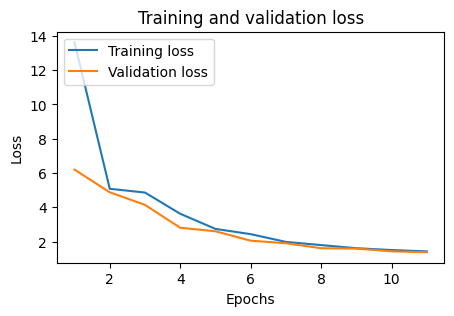

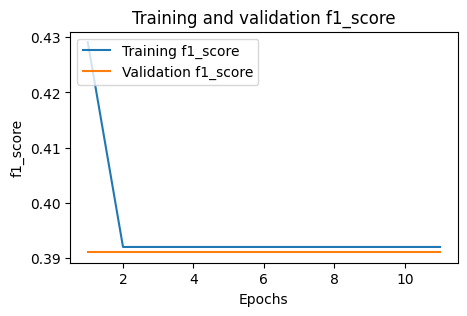

146/146 [==============================] - 0s 596us/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      2488
         1.0       0.64      1.00      0.78      4500

    accuracy                           0.64      6988
   macro avg       0.82      0.50      0.39      6988
weighted avg       0.77      0.64      0.50      6988

```

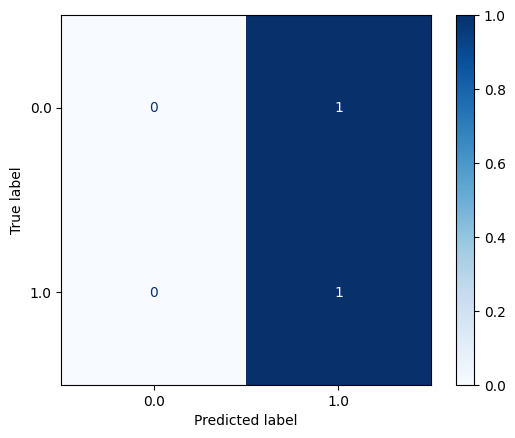

#### Optimal Threshold: 0.00
```
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      2488
         1.0       0.64      1.00      0.78      4500

    accuracy                           0.64      6988
   macro avg       0.82      0.50      0.39      6988
weighted avg       0.77      0.64      0.50      6988

```

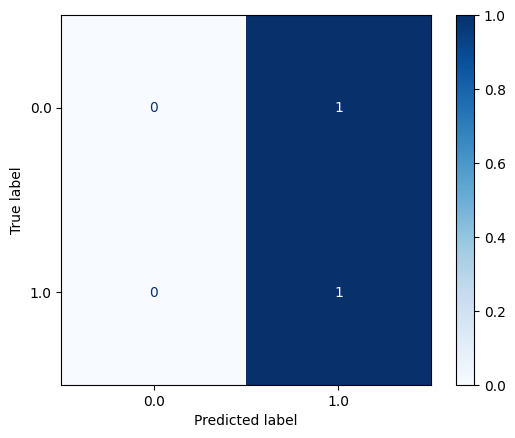

1/1 [==============================] - 0s 34ms/step
2023-04-11 15:11:52 WARNING  Found untraced functions such as leaky_re_lu_layer_call_fn, leaky_re_lu_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /tmp/tmp3hlmkub0/model/data/model/assets
2023-04-11 15:11:52 INFO     Assets written to: /tmp/tmp3hlmkub0/model/data/model/assets


KeyboardInterrupt: 

In [19]:
# find the best model
for batch_size in [500, 1000, 2000, 3000, 4000]:
    for optimizer in [optimizers.Adam, optimizers.RMSprop]:
        sd_model.tune_model(
            define_tune_parameters=define_tune_parameters,
            dataset=cat_features_dataset,
            max_trials=50,
            input_shape=features_dataset_shape,
            output_shape=output_shape,
            dense_layer_count='dense_layer_count',
            dense_units='dense_units',
            dense_activation='dense_activation',
            dense_l1_regularization='dense_l1_regularization',
            dense_l2_regularization='dense_l2_regularization',
            dense_dropout='dense_dropout',
            train_epochs=2000,
            train_batch_size=batch_size,
            train_optimizer=optimizer,
            train_learning_rate='learning_rate',
            train_loss='categorical_crossentropy',
            train_metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')],
            train_class_weight=None,
            tune_objective='val_f1_score',
            tune_direction='max',
            tuner_type=kt.tuners.BayesianOptimization,
            tune_patience=10)

### Combined Features

In [20]:
# configure mlflow
mlflow.set_experiment("question-11-heatmap")
mlflow.keras.autolog()

2023/04/11 15:12:09 INFO mlflow.tracking.fluent: Experiment with name 'question-11-heatmap' does not exist. Creating a new experiment.


In [21]:
# create the heatmap dataset
heatmap_dataset = md.get_feature_dataset(
    features=df_question_features,
    y=df_question_labels,
    feature_list=['screen_heatmap_feature'],
    train=train,
    val=val,
    test=test,
    include_question=False,
    expand_question=False)

2023-04-11 15:12:17 INFO     -- Creating the train dataset
2023-04-11 15:12:17 INFO     Creating the dataset for all level groups


  0%|          | 0/3495 [00:00<?, ?it/s]

2023-04-11 15:12:22 INFO     -- Creating the val dataset
2023-04-11 15:12:22 INFO     Creating the dataset for all level groups


  0%|          | 0/1165 [00:00<?, ?it/s]

2023-04-11 15:12:24 INFO     -- Creating the test dataset
2023-04-11 15:12:24 INFO     Creating the dataset for all level groups


  0%|          | 0/6988 [00:00<?, ?it/s]

In [22]:
# define the flat heatmap input shape
input_data = heatmap_dataset['train']['X']
heatmap_shape = input_data.shape[1], input_data.shape[2], input_data.shape[3]
print('heatmap_shape:', heatmap_shape)

# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

heatmap_shape: (23, 10, 10)
features_dataset_shape: 23
output_shape 2


In [23]:
# define the tuner parameters
def define_heatmap_tune_parameters(hp):
    # add the simple model parameters
    define_tune_parameters(hp)

    # add the heatmap model parameters
    hp.Int('covnet_block_count', min_value=1, max_value=3, step=1)
    hp.Choice('covnet_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Int('covnet_cov_count', min_value=1, max_value=3, step=1)
    hp.Int('covnet_channels', min_value=32, max_value=64, step=16)
    hp.Choice('covnet_kernel_size', values=['(3, 3)'])
    hp.Choice('covnet_pool_size', values=['(2, 2)'])

In [24]:
# create the model object
heatmap_model = HeatmapCovnetModel(
    input_shape=features_dataset_shape,
    heatmap_shape=heatmap_shape,
    output_shape=output_shape,
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')])

In [25]:
mlflow.end_run()

In [26]:
# find the best model
for batch_size in [500, 1000, 2000, 3000, 4000]:
    for optimizer in [optimizers.Adam, optimizers.RMSprop]:
        model = heatmap_model.tune_model(
            define_tune_parameters=define_heatmap_tune_parameters,
            heatmap_dataset=heatmap_dataset,
            feature_dataset=cat_features_dataset,
            max_trials=50,
            train_epochs=1000,
            train_batch_size=batch_size,
            train_optimizer=optimizer,
            tuner_type=kt.tuners.RandomSearch,
            tune_objective='val_f1_score',
            tune_direction='max',
            train_class_weight=None,
            tune_patience=10)
        
        mlflow.end_run()

Trial 50 Complete [00h 00m 06s]
val_f1_score: 0.3937683701515198

Best val_f1_score So Far: 0.6545993089675903
Total elapsed time: 00h 06m 55s
INFO:tensorflow:Oracle triggered exit
2023-04-11 16:18:11 INFO     Oracle triggered exit
{'dense_layer_count': 5, 'dense_units': 608, 'dense_activation': 'relu', 'dense_l1_regularization': 0.00019, 'dense_l2_regularization': 0.0006000000000000001, 'dense_dropout': 0.015, 'learning_rate': 1e-06, 'covnet_block_count': 3, 'covnet_activation': 'LeakyReLU', 'covnet_cov_count': 2, 'covnet_channels': 48, 'covnet_kernel_size': '(3, 3)', 'covnet_pool_size': '(2, 2)'}
2023-04-11 16:18:12 INFO     Creating a heatmap CNN model
2023-04-11 16:18:12 INFO     block 0
2023-04-11 16:18:12 INFO     cov 0
2023-04-11 16:18:12 INFO     cov 1
2023-04-11 16:18:12 INFO     block 1
2023-04-11 16:18:12 INFO     cov 0
2023-04-11 16:18:12 INFO     cov 1
2023-04-11 16:18:12 INFO     block 2
2023-04-11 16:18:12 INFO     cov 0
2023-04-11 16:18:12 INFO     cov 1
37/37 [========

### Save the best model

In [43]:
# load the best model from mlflow
model_uri = "runs:/4fe106f5e4e645bb8d9c411525e58ddb/model"
q11_model = mlflow.keras.load_model(model_uri)

# save the model to disk
k.models.save_model(q11_model, "../data/interim/model_03-204.h5")

## Model Evaluation

In [44]:
# load the test session ids
test = np.load('../data/interim/test_03-202.npy')

# load the models
q05_model = k.models.load_model('../data/interim/model_03-202.h5')
q10_model = k.models.load_model('../data/interim/model_03-203.h5')
q11_model = k.models.load_model('../data/interim/model_03-204.h5')

In [45]:
# select all the records in the training set
df_test = df_source[df_source.session_id.isin(test)]

# select the last record for each session
df_test_labels = df_source_labels[df_source_labels.session_id.isin(test)]

### Create Predictor

In [46]:
# create the predictor object
models = {
    5:  {'model': q05_model, 'threshold': 0.52},
    10: {'model': q10_model, 'threshold': 0.50},
    11: {'model': q11_model, 'threshold': 0.55}
}

predictor = HeatmapPredictor(models)

### Question 11

In [47]:
# select the data labels for the specific question
df_q_labels = df_test_labels[df_test_labels.question_num == 11]
q_level_groups = df_q_labels.level_group.unique()

# select the source data for the question
df_q = df_test[df_test.level_group.isin(q_level_groups)]

In [48]:
# get the test data labels
y_true = df_q_labels['correct']

In [49]:
# perform the predictions
base_model:Baseline = Baseline()
df_q_baseline = base_model.predict(data=df_q, labels=df_q_labels)
y_pred_baseline = df_q_baseline['correct']

2023-04-11 18:00:06 INFO     Predicting the target variable


  0%|          | 0/6988 [00:00<?, ?it/s]

In [50]:
# perform predictions with the actual models
q_predictor = HeatmapPredictor(models={
    11: {'model': q11_model, 'threshold': 0.55}
})

df_q_model = q_predictor.predict(data=df_q, labels=df_q_labels)
y_pred_model = df_q_model['correct']

2023-04-11 18:00:19 INFO     Performing feature engineering:
2023-04-11 18:00:19 INFO     	Adding elapsed time features...
2023-04-11 18:00:19 INFO     	Adding total count features...
2023-04-11 18:00:20 INFO     	Adding unique count features...
2023-04-11 18:00:20 INFO     	Adding heatmap features...


  0%|          | 0/6988 [00:00<?, ?it/s]

2023-04-11 18:03:16 INFO     Predicting the target variable


  0%|          | 0/6988 [00:00<?, ?it/s]

In [51]:
# show the classification report
mprint('#### Baseline')
mprint('```')
mprint(classification_report(y_true, y_pred_baseline, zero_division=0))
mprint('```')

mprint('#### Model')
mprint('```')
mprint(classification_report(y_true, y_pred_model, zero_division=0))
mprint('```')

mflush()

#### Baseline
```
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2488
           1       0.64      1.00      0.78      4500

    accuracy                           0.64      6988
   macro avg       0.32      0.50      0.39      6988
weighted avg       0.41      0.64      0.50      6988

```
#### Model
```
              precision    recall  f1-score   support

           0       0.47      0.45      0.46      2488
           1       0.70      0.72      0.71      4500

    accuracy                           0.62      6988
   macro avg       0.59      0.59      0.59      6988
weighted avg       0.62      0.62      0.62      6988

```

### All Questions

In [52]:
# get the test data labels
y_true = df_test_labels['correct']

In [53]:
# perform the baseline predictions
base_model:Baseline = Baseline()
df_baseline = base_model.predict(data=df_test, labels=df_test_labels)
y_pred_baseline = df_baseline['correct']

2023-04-11 18:07:17 INFO     Predicting the target variable


  0%|          | 0/125784 [00:00<?, ?it/s]

In [54]:
# perform predictions with the model
q_predictor = HeatmapPredictor(models={
    11: {'model': q11_model, 'threshold': 0.55}
})

df_model = q_predictor.predict(data=df_test, labels=df_test_labels)
y_pred_model = df_model['correct']

2023-04-11 18:15:27 INFO     Performing feature engineering:
2023-04-11 18:15:27 INFO     	Adding elapsed time features...
2023-04-11 18:15:29 INFO     	Adding total count features...
2023-04-11 18:15:29 INFO     	Adding unique count features...
2023-04-11 18:15:31 INFO     	Adding heatmap features...


  0%|          | 0/6988 [00:00<?, ?it/s]

In [ ]:
# show the classification report
mprint('#### Baseline')
mprint('```')
mprint(classification_report(y_true, y_pred_baseline, zero_division=0))
mprint('```')

mprint('#### Model')
mprint('```')
mprint(classification_report(y_true, y_pred_model, zero_division=0))
mprint('```')

mflush()

### Question 5, 10, and 11 models combined

In [ ]:
# perform predictions with the model
q_predictor = HeatmapPredictor(models={
    5:  {'model': q05_model, 'threshold': 0.52},
    10: {'model': q10_model, 'threshold': 0.50},
    11: {'model': q11_model, 'threshold': 0.55}
})

df_model = q_predictor.predict(data=df_test, labels=df_test_labels)
y_pred_model = df_model['correct']

In [ ]:
mprint('#### Model')
mprint('```')
mprint(classification_report(y_true, y_pred_model, zero_division=0))
mprint('```')

mflush()